In [ ]:
import shutil

extraction_path = '/content/drive/MyDrive/Abdelrahman_s/new_new'

try:
    shutil.rmtree(extraction_path)  # This will delete the directory and its contents
    print(f"Deleted {extraction_path}")
except FileNotFoundError:
    print(f"{extraction_path} not found")
except PermissionError:
    print(f"Permission denied to delete {extraction_path}")
except Exception as e:
    print(f"An error occurred: {str(e)}")


In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/Abdelrahman_s/new.zip'
extraction_path = '/content/drive/MyDrive/Abdelrahman_s/new_new/images'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import cv2

In [ ]:
train_csv_path = '/content/drive/MyDrive/Abdelrahman_s/train.csv'
valid_csv_path = '/content/drive/MyDrive/Abdelrahman_s/valid.csv'
test_csv_path = '/content/drive/MyDrive/Abdelrahman_s/test.csv'
image_folder = '/content/drive/MyDrive/Abdelrahman_s/new_new/images/new_new_images'
train_df = pd.read_csv(train_csv_path)
valid_df = pd.read_csv(valid_csv_path)
test_df = pd.read_csv(test_csv_path)
img_width = int(train_df['width'].values[0])
img_height = int(train_df['height'].values[0])
batch_size = 32
num_classes = len(train_df['class'].unique())

In [ ]:
def gamma_correction(img, gamma=1.0):
    # Apply gamma correction to each channel
    corrected_img = np.zeros_like(img, dtype=np.float32)
    for channel in range(img.shape[2]):
        corrected_img[:, :, channel] = np.interp(img[:, :, channel], np.arange(0, 256), ((np.arange(0, 256) / 255.0) ** (1.0 / gamma)) * 255).astype(np.uint8)
    return corrected_img

In [ ]:
def image_exists(image_path):
    return os.path.exists(os.path.join(image_folder, image_path))
# Filter out rows where the image file does not exist
train_df = train_df[train_df['filename'].apply(image_exists)]
valid_df = valid_df[valid_df['filename'].apply(image_exists)]
test_df = test_df[test_df['filename'].apply(image_exists)]

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.1,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_original = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.1
)

train_generator = datagen.flow_from_dataframe(
    train_df,
    directory=image_folder,
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_generator = datagen.flow_from_dataframe(
    valid_df,
    directory=image_folder,
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    directory=image_folder,
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers[-10:]:
    layer.trainable = True
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_checkpoint_Resnet_2.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=200,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)



In [ ]:
model.save('/content/drive/MyDrive/Abdelrahman_s/new_new/final_model_Resnet_2.h5')
model.save('final_model_Resnet_2.h5')
model.save('model_checkpoint_Resnet_2.h5')
model.save('/content/drive/MyDrive/Abdelrahman_s/new_new/model_checkpoint_Resnet_2.h5')
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


In [ ]:
cd '/content/drive/MyDrive/Abdelrahman_s/new_new/tensorboard_logs'


/content/drive/MyDrive/Abdelrahman_s/new_new/tensorboard_logs


In [ ]:
!tensorboard --logdir=.


2024-01-19 19:18:28.731852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 19:18:28.731922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 19:18:28.733473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 19:18:28.741495: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 19:18:29.795890: W tensorflow/compiler/tf2

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Abdelrahman_s/new_new/tensorboard_logs


<IPython.core.display.Javascript object>

System architecture diagram saved as 'system_architecture.png'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/final_model_Resnet_2.h5')


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess the new images
image_paths = ['/content/image2.jpg', '/content/slide25.png','/content/slide13.png','/content/image.jpg']
new_images = []

for image_path in image_paths:
    img = load_img(image_path, target_size=(img_width, img_height))
    img = img_to_array(img)
    img = img / 255.0  # Rescale to the range [0, 1]
    new_images.append(img)

new_images = np.array(new_images)


In [ ]:
predictions = model.predict(new_images)
class_labels = train_generator.class_indices
predicted_labels = [list(class_labels.keys())[np.argmax(pred)] for pred in predictions]


1/1 [==============================] - 1s 1s/step


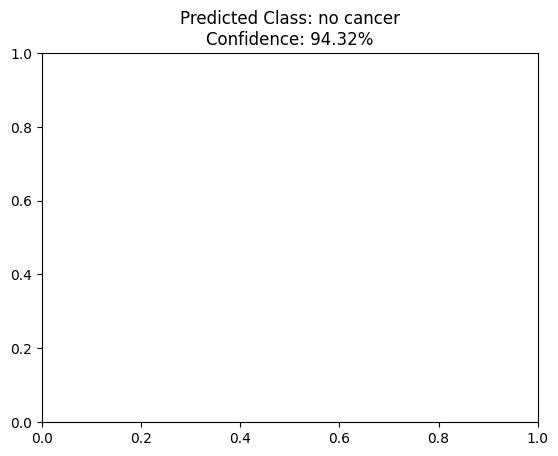

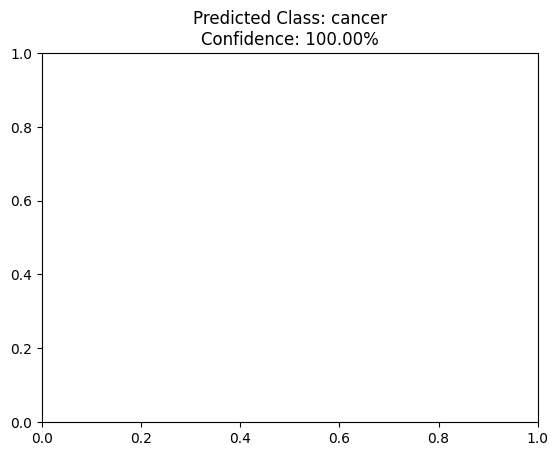

In [ ]:
import matplotlib.pyplot as plt
for i in range(len(image_paths)):
    # Load the image
    img = load_img(image_paths[i], target_size=(img_width, img_height))
    #plt.figure()
    #plt.imshow(img)
    #plt.axis('off')

    # Display image information
    plt.title(f"Predicted Class: {predicted_labels[i]}\nConfidence: {predictions[i].max() * 100:.2f}%")
    plt.show()
